In [1]:
import numpy as np
from tensorflow import keras
import utils

In [2]:
history_steps = 50
forecast_steps = 10
series = utils.generate_time_series(10000, history_steps + forecast_steps)
print(f"series.shape = {series.shape}")

x_train = series[:7000, :history_steps]
x_val = series[7000:9000, :history_steps]
x_test = series[9000:, :history_steps]
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)

y = np.empty((10000, history_steps, forecast_steps))
for step_ahead in range(1, forecast_steps + 1):
    y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + history_steps]
y_train = y[:7000]
y_val = y[7000:9000]
y_test = y[9000:]

print(f"x_train.shape = {x_train.shape}, y_train.shape = {y_train.shape}")
print(f"x_val.shape = {x_val.shape}, y_val.shape = {y_val.shape}")
print(f"x_test.shape = {x_test.shape}, y_test.shape = {y_test.shape}")

series.shape = (10000, 60)
x_train.shape = (7000, 50, 1), y_train.shape = (7000, 50, 10)
x_val.shape = (2000, 50, 1), y_val.shape = (2000, 50, 10)
x_test.shape = (1000, 50, 1), y_test.shape = (1000, 50, 10)


In [3]:
utils.reset_session()

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

def last_time_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

optimizer=keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', last_time_step_mse])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20)          80        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 20)          80        
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,630
Trainable params: 1,550
Non-trainable params: 80
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0759 - mae: 0.1921 - last_time_step_mse: 0

In [4]:
series = utils.generate_time_series(1, history_steps + forecast_steps, seed=43)
print(f"series.shape = {series.shape}")
x_new, y_new = series[:, :history_steps], series[:, -forecast_steps:]
x_new = np.expand_dims(x_new, -1)
print(f"x_new.shape = {x_new.shape}, y_new.shape = {y_new.shape}")

series.shape = (1, 60)
x_new.shape = (1, 50, 1), y_new.shape = (1, 10)


In [5]:
y_pred = model.predict(x_new)
y_pred.shape

(1, 50, 10)

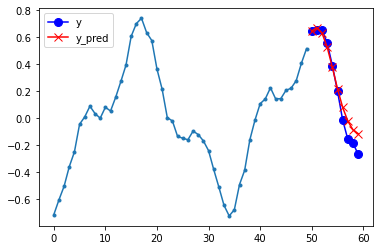

In [6]:
utils.plot_series_multiple_forecasts(x_new, y_new, y_pred[0, -1, :])